<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорты

In [1]:
# !pip install pymystem3 -q
# !pip install transformers -q
# !pip install emoji -q
# !pip install imblearn -q
# !pip install sentence_transformers -q
# !pip install hf_xet -q

In [2]:
# =============================
# TIMER
# =============================
import time
start = time.time()

# =============================
# STANDARD LIBRARY
# =============================
import os
import re
import random
import logging
import warnings

# =============================
# NUMERIC / DATA
# =============================
import numpy as np
import pandas as pd

# =============================
# SKLEARN
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    f1_score,
    precision_recall_curve,
    make_scorer,
)
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# =============================
# BOOSTING
# =============================
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# =============================
# NLP (NLTK)
# =============================
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords as nltk_stopwords
from nltk import pos_tag
from nltk.tokenize import TreebankWordTokenizer  # вместо word_tokenize

# =============================
# TEXT UTILITIES
# =============================
import emoji
from wordcloud import WordCloud, STOPWORDS
from matplotlib import font_manager
import matplotlib.pyplot as plt

# =============================
# PYTORCH
# =============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

# =============================
# TRANSFORMERS
# =============================
import transformers
from transformers import (
    BertTokenizer,
    BertConfig,
    BertModel,
    AutoTokenizer,
    AutoModel,
)
from sentence_transformers import SentenceTransformer

# =============================
# OPTIMIZATION
# =============================
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

# =============================
# UTILITIES
# =============================
from tqdm import tqdm, notebook
tqdm.pandas()

# =============================
# LOGGING
# =============================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# =============================
# WARNINGS
# =============================
warnings.filterwarnings("ignore")

e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ===== ОТКЛЮЧАЕМ TORCHDYNAMO / TRITON =====

os.environ["TORCHDYNAMO_DISABLE"] = "1"
torch._dynamo.disable()

# ===== TRANSFORMERS =====
MODEL_NAME = "unitary/toxic-bert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# ===== DEVICE =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

logger.info(f"Model loaded on device: {device}")

# ===== NLTK CONFIG (ЛОКАЛЬНЫЙ nltk_data) =====
NLTK_DATA_DIR = os.path.abspath("./nltk_data")
os.makedirs(NLTK_DATA_DIR, exist_ok=True)

if NLTK_DATA_DIR not in nltk.data.path:
    nltk.data.path.append(NLTK_DATA_DIR)

# ===== ЗАГРУЗКА ОБЯЗАТЕЛЬНЫХ РЕСУРСОВ NLTK =====
nltk_packages = {
    "punkt": "tokenizers/punkt",
    "stopwords": "corpora/stopwords",
    "wordnet": "corpora/wordnet",
    "omw-1.4": "corpora/omw-1.4",
    "averaged_perceptron_tagger": "taggers/averaged_perceptron_tagger",
    "vader_lexicon": "sentiment/vader_lexicon"
}

for pkg, path in nltk_packages.items():
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(pkg, download_dir=NLTK_DATA_DIR, quiet=False)

2026-01-14 21:14:13 [INFO] __main__: Model loaded on device: cuda
[nltk_data] Downloading package wordnet to
[nltk_data]     e:\my_github\yandex_practicum_ds\15)
[nltk_data]     Mashinnoe_obuchenie_text\project\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     e:\my_github\yandex_practicum_ds\15)
[nltk_data]     Mashinnoe_obuchenie_text\project\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     e:\my_github\yandex_practicum_ds\15)
[nltk_data]     Mashinnoe_obuchenie_text\project\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Константы

In [4]:
MAX_LENGTH = 512
BATCH_SIZE = 32
CV = 3
N_OPTUNA = 10
TEST_SIZE = 0.2
RANDOM_STATE = 20
N_EPOCHS = 10000
EARLY_STOP = 5

def seed_everything(seed=RANDOM_STATE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

seed_everything()

In [5]:
# df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])
df = pd.read_csv('./data/toxic_comments.csv', index_col=[0])
display(df.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Подготовка текста

In [6]:
EMOJI_PATTERN = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FAFF"
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE
)

def bert_clean(text: str) -> str:
    """
    Очистка текста для BERT:
    - убираем ссылки,
    - заменяем несколько пробелов на один,
    - убираем эмодзи,
    - приводим к нижнему регистру,
    - обрезаем лишние пробелы по краям.
    """
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = EMOJI_PATTERN.sub("", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df['text_clean'] = df['text'].progress_apply(bert_clean)

100%|██████████| 159292/159292 [00:04<00:00, 38727.85it/s]


In [7]:
display(df.sample(5))

,text,toxic,text_clean
74297,"Adoption?\nHi, Katie. I am also interested in ...",0,"adoption? hi, katie. i am also interested in a..."
53437,"""\n\n WP:APPLE's Backlog Elimination Drive is ...",0,""" wp:apple's backlog elimination drive is over..."
68821,Your recent removal of some text at Global Pos...,0,your recent removal of some text at global pos...
14003,"No, we don't need anyone to say explicitly tha...",0,"no, we don't need anyone to say explicitly tha..."
155348,"Piss off, she is an ignorant bitch.",1,"piss off, she is an ignorant bitch."


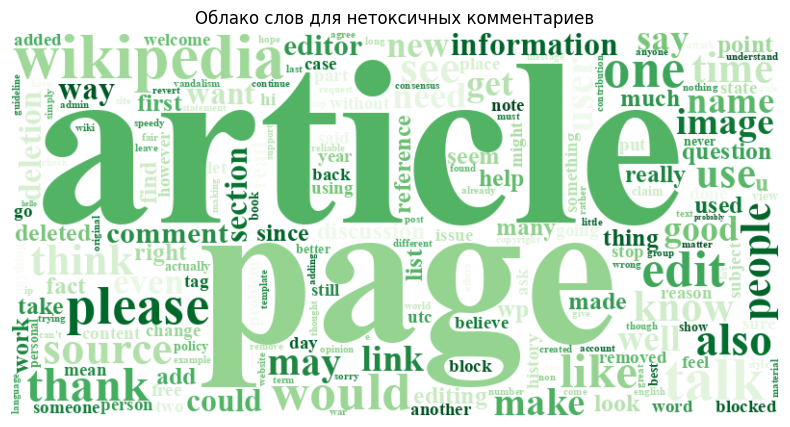

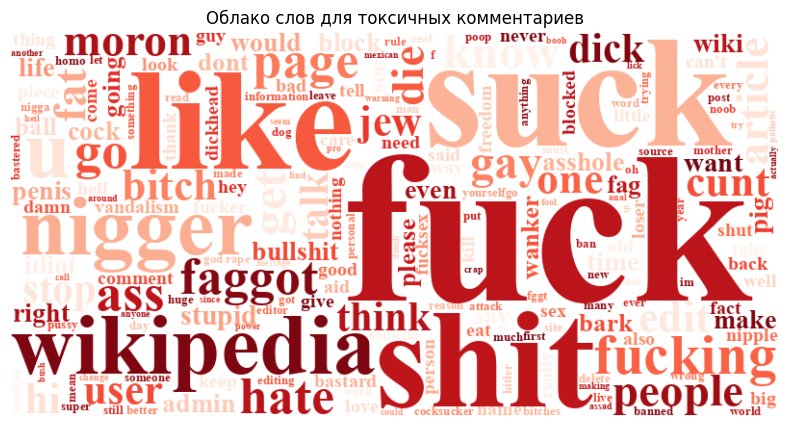

In [8]:
# стоп-слова
stopwords_en = set(nltk_stopwords.words("english"))

# --- ищем шрифт по имени ---
def find_font(name_substr: str) -> str:
    for path in font_manager.findSystemFonts(fontext="ttf"):
        if name_substr.lower() in path.lower():
            return path
    raise RuntimeError(f"Шрифт '{name_substr}' не найден")

font_path = find_font("Times")  # можно "Times New Roman", "DejaVuSansMono", "Courier" и др.

# --- генерация облака слов ---
for label, cmap in zip([0, 1], ["Greens", "Reds"]):
    texts = df.loc[df["toxic"] == label, "text_clean"].dropna().astype(str)

    if texts.empty:
        continue

    text = " ".join(texts)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stopwords_en,
        colormap=cmap,
        max_words=200,
        font_path=font_path,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Облако слов для {'токсичных' if label == 1 else 'нетоксичных'} комментариев")
    plt.show()

In [9]:
analyzer = SentimentIntensityAnalyzer()

def add_text_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["word_count"] = df["text"].str.split().apply(len)

    df["avg_word_len"] = df["text"].apply(
        lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0
    )

    df["sentiment"] = df["text"].apply(
        lambda x: analyzer.polarity_scores(str(x))["compound"]
    )

    return df


df = add_text_features(df)

In [10]:
num_features = ["word_count", "avg_word_len", "sentiment"]

stats = (
    df
    .groupby("toxic")[num_features]
    .mean()
    .T
)

display(stats)

toxic,0,1
word_count,68.857665,52.677314
avg_word_len,4.910278,5.168201
sentiment,0.162063,-0.394177


In [11]:
df_train, df_test = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df["toxic"]
)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

logger.info(f"Train size: {len(df_train)}, Test size: {len(df_test)}")

2026-01-14 21:15:46 [INFO] __main__: Train size: 127433, Test size: 31859


In [12]:
def get_embeddings(df_part, tokenizer, model, device, batch_size, max_length, desc):
    all_embeddings = []

    model.eval()

    for i in tqdm(range(0, len(df_part), batch_size), desc=desc):
        batch_texts = df_part['text_clean'].iloc[i:i + batch_size].tolist()

        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )

            # CLS embedding
            embeddings = outputs.last_hidden_state[:, 0, :]

            # L2-нормализация (важно для линейных моделей)
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

        all_embeddings.append(embeddings.cpu().numpy())

    return np.vstack(all_embeddings)

In [13]:
# пути для сохранения эмбеддингов
train_emb_path = "./data/X_train_emb.npy"
test_emb_path = "./data/X_test_emb.npy"
train_labels_path = "./data/y_train.npy"
test_labels_path = "./data/y_test.npy"

# ===== TRAIN =====
if os.path.exists(train_emb_path) and os.path.exists(train_labels_path):
    X_train = np.load(train_emb_path)
    y_train = np.load(train_labels_path)
    logger.info(f"Загружены кэшированные эмбеддинги TRAIN: {X_train.shape}")
else:
    X_train = get_embeddings(
        df_part=df_train,
        tokenizer=tokenizer,
        model=model,
        device=device,
        batch_size=BATCH_SIZE,
        max_length=MAX_LENGTH,
        desc="Train embeddings"
    )
    y_train = df_train["toxic"].values
    np.save(train_emb_path, X_train)
    np.save(train_labels_path, y_train)
    logger.info(f"Сгенерированы и сохранены эмбеддинги TRAIN: {X_train.shape}")

# ===== TEST =====
if os.path.exists(test_emb_path) and os.path.exists(test_labels_path):
    X_test = np.load(test_emb_path)
    y_test = np.load(test_labels_path)
    logger.info(f"Загружены кэшированные эмбеддинги TEST: {X_test.shape}")
else:
    X_test = get_embeddings(
        df_part=df_test,
        tokenizer=tokenizer,
        model=model,
        device=device,
        batch_size=BATCH_SIZE,
        max_length=MAX_LENGTH,
        desc="Test embeddings"
    )
    y_test = df_test["toxic"].values
    np.save(test_emb_path, X_test)
    np.save(test_labels_path, y_test)
    logger.info(f"Сгенерированы и сохранены эмбеддинги TEST: {X_test.shape}")


2026-01-14 21:15:46 [INFO] __main__: Загружены кэшированные эмбеддинги TRAIN: (127433, 768)
2026-01-14 21:15:46 [INFO] __main__: Загружены кэшированные эмбеддинги TEST: (31859, 768)


## Обучение

In [14]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [15]:
# Проверяем баланс классов
logger.info(f"Распределение классов в train: {np.bincount(y_train)}")
logger.info(f"Доля positive класса: {y_train.mean():.3f}")

2026-01-14 21:15:46 [INFO] __main__: Распределение классов в train: [114484  12949]
2026-01-14 21:15:46 [INFO] __main__: Доля positive класса: 0.102


In [16]:
# ===== объединяем BERT + ручные фичи =====
X_train_full = np.hstack([
    X_train,
    df_train[num_features].values
])

X_test_full = np.hstack([
    X_test,
    df_test[num_features].values
])

y = y_train

scorer = make_scorer(f1_score)

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ),

    "RidgeClassifier": RidgeClassifier(
        class_weight="balanced"
    ),

    "LinearSVC": LinearSVC(
        class_weight="balanced",
        max_iter=5000
    ),

    "KNN": KNeighborsClassifier(
        n_neighbors=15,
        weights="distance",
        metric="cosine"
    ),

    "LGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=64,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=-1
    )
}

best_models = {}

for name, clf in models.items():

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])

    cv = StratifiedKFold(
        n_splits=CV,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    scores = cross_val_score(
        pipe,
        X_train_full,
        y,
        cv=cv,
        scoring=scorer,
        n_jobs=-1
    )

    best_models[name] = {
        "cv_f1_mean": scores.mean(),
        "cv_f1_std": scores.std(),
        "pipeline": pipe
    }

    logger.info(
        f"{name} | F1 CV: {scores.mean():.4f} +- {scores.std():.4f}"
    )

# ===== выбор лучшей =====
best_model_name = max(
    best_models,
    key=lambda k: best_models[k]["cv_f1_mean"]
)

best_pipe = best_models[best_model_name]["pipeline"]

# ===== финальное обучение =====
best_pipe.fit(X_train_full, y_train)

y_pred_test = best_pipe.predict(X_test_full)
test_f1 = f1_score(y_test, y_pred_test)

logger.info(
    f"BEST MODEL: {best_model_name} | TEST F1 = {test_f1:.4f}"
)

2026-01-14 21:16:36 [INFO] __main__: LogisticRegression | F1 CV: 0.9250 +- 0.0010
2026-01-14 21:16:48 [INFO] __main__: RidgeClassifier | F1 CV: 0.9138 +- 0.0006
2026-01-14 21:20:06 [INFO] __main__: LinearSVC | F1 CV: 0.9240 +- 0.0009
2026-01-14 21:23:30 [INFO] __main__: KNN | F1 CV: 0.9400 +- 0.0015
2026-01-14 21:24:53 [INFO] __main__: LGBM | F1 CV: 0.9450 +- 0.0013
2026-01-14 21:25:31 [INFO] __main__: BEST MODEL: LGBM | TEST F1 = 0.9416


In [ ]:
# нейронка
/''
X_cv = X_train.astype(np.float32)
y_cv = y_train.astype(np.int64)


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, 2)
        )

    def forward(self, x):
        return self.model(x)


def train_model(
    model,
    train_dataset,
    val_dataset,
    lr,
    batch_size,
    n_epochs=N_EPOCHS,
    patience=EARLY_STOP,
    log_every=10
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # class weights для CrossEntropy
    y_train_local = train_dataset.tensors[1].numpy()
    class_counts = np.bincount(y_train_local)
    class_weights = class_counts.sum() / (2 * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_f1 = 0.0
    best_state = None
    trigger = 0

    model.to(device)

    for epoch in range(1, n_epochs + 1):
        # ===== TRAIN =====
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        # ===== VALIDATION =====
        model.eval()
        all_preds, all_labels = [], []
        val_loss = 0.0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                val_loss += criterion(logits, yb).item() * xb.size(0)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu())
                all_labels.append(yb.cpu())

        val_loss /= len(val_loader.dataset)
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        val_f1 = f1_score(all_labels, all_preds)

        # ===== LOGGING =====
        if epoch % log_every == 0 or epoch == 1:
            logger.info(
                f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}"
            )

        # ===== EARLY STOPPING =====
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                logger.info(f"Early stopping at epoch {epoch}")
                break

    model.load_state_dict(best_state)
    return model, best_val_f1


def objective_mlp(trial):
    seed_everything()

    hidden_dim1 = trial.suggest_int("hidden_dim1", 512, 1024)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 256, 512)
    dropout = trial.suggest_float("dropout", 0.05, 0.2)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    cv = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RANDOM_STATE)
    scores = []

    for train_idx, val_idx in cv.split(X_cv, y_cv):
        train_ds = TensorDataset(
            torch.from_numpy(X_cv[train_idx]),
            torch.from_numpy(y_cv[train_idx])
        )
        val_ds = TensorDataset(
            torch.from_numpy(X_cv[val_idx]),
            torch.from_numpy(y_cv[val_idx])
        )

        model = MLP(X_cv.shape[1], hidden_dim1, hidden_dim2, dropout)
        _, f1 = train_model(model, train_ds, val_ds, lr, batch_size)
        scores.append(f1)

    return float(np.mean(scores))


# ===== OPTUNA HYPERPARAMETER TUNING =====
study = optuna.create_study(direction="maximize")
study.optimize(objective_mlp, n_trials=N_OPTUNA)

best_params = study.best_trial.params
logger.info(f"MLP best params: {best_params}")
logger.info(f"MLP CV F1: {study.best_value:.4f}")


# ===== FINAL TRAIN WITH HOLDOUT =====
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=RANDOM_STATE
)

final_model = MLP(
    X_train.shape[1],
    best_params["hidden_dim1"],
    best_params["hidden_dim2"],
    best_params["dropout"]
)

train_ds = TensorDataset(
    torch.from_numpy(X_tr.astype(np.float32)),
    torch.from_numpy(y_tr.astype(np.int64))
)
val_ds = TensorDataset(
    torch.from_numpy(X_val.astype(np.float32)),
    torch.from_numpy(y_val.astype(np.int64))
)

final_model, _ = train_model(
    final_model,
    train_ds,
    val_ds,
    lr=best_params["lr"],
    batch_size=best_params["batch_size"],
    log_every=10
)


# ===== TEST =====
final_model.eval()
final_model.to(device)

test_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(X_test.astype(np.float32)),
        torch.from_numpy(y_test.astype(np.int64))
    ),
    batch_size=best_params["batch_size"],
    shuffle=False
)

preds, labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds.append(torch.argmax(final_model(xb), dim=1).cpu())
        labels.append(yb.cpu())

test_f1 = f1_score(torch.cat(labels), torch.cat(preds))
logger.info(f"MLP TEST F1: {test_f1:.4f}")

2026-01-14 21:25:35 [INFO] __main__: Epoch 001 | Train Loss: 0.0743 | Val Loss: 0.0540 | Val F1: 0.8992
2026-01-14 21:25:58 [INFO] __main__: Early stopping at epoch 7
2026-01-14 21:26:02 [INFO] __main__: Epoch 001 | Train Loss: 0.0742 | Val Loss: 0.0552 | Val F1: 0.8994
2026-01-14 21:26:31 [INFO] __main__: Epoch 010 | Train Loss: 0.0463 | Val Loss: 0.0519 | Val F1: 0.8991
2026-01-14 21:26:37 [INFO] __main__: Early stopping at epoch 12
2026-01-14 21:26:40 [INFO] __main__: Epoch 001 | Train Loss: 0.0758 | Val Loss: 0.0522 | Val F1: 0.9344
2026-01-14 21:26:56 [INFO] __main__: Early stopping at epoch 6
2026-01-14 21:26:59 [INFO] __main__: Epoch 001 | Train Loss: 0.0620 | Val Loss: 0.0920 | Val F1: 0.8866
2026-01-14 21:27:31 [INFO] __main__: Epoch 010 | Train Loss: 0.0529 | Val Loss: 0.0485 | Val F1: 0.9314
2026-01-14 21:27:31 [INFO] __main__: Early stopping at epoch 10
2026-01-14 21:27:35 [INFO] __main__: Epoch 001 | Train Loss: 0.0594 | Val Loss: 0.0519 | Val F1: 0.9151
2026-01-14 21:27:5

In [18]:
elapsed = time.time() - start

h, rem = divmod(elapsed, 3600)
m, s = divmod(rem, 60)

logger.info(f"{int(h):02d}:{int(m):02d}:{int(s):02d}")

2026-01-14 21:39:30 [INFO] __main__: 00:25:27


## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны